In [ ]:
# eksport file csv ke drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# inisialisasi libraries

# Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')


from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
# read csv file
loan_data = '/content/drive/MyDrive/File_Data /loan_data_2007_2014.csv'
loan_df = pd.read_csv(loan_data)
loan_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

Data ini terdiri dari 466.285 baris yang berisi 74 kolom

In [ ]:
# Persebaran Missing Values

na_value_counts = np.array([loan_df[col].isna().sum() for col in loan_df.columns])
perc_na_value_counts = (na_value_counts*100)/(len(loan_df))

na_dict = {'Kolom' : loan_df.columns, 'Missing Values Percentage' : perc_na_value_counts}
na_df = pd.DataFrame(na_dict).sort_values('Missing Values Percentage', ascending = False).reset_index().drop('index', axis = 1)

# Menampilkan kolom missing value 30 teratas
na_df.head(30)

,Kolom,Missing Values Percentage
0,inq_last_12m,100.000000
1,total_bal_il,100.000000
2,dti_joint,100.000000
3,verification_status_joint,100.000000
4,annual_inc_joint,100.000000
5,open_acc_6m,100.000000
6,open_il_6m,100.000000
7,open_il_12m,100.000000
8,open_il_24m,100.000000
9,mths_since_rcnt_il,100.000000


Ada 17 kolom yang hanya mengandung missing values

In [ ]:
# Buat data histogram
loan_amount, funded_amount, investor_committment = loan_df['loan_amnt'], loan_df['funded_amnt'], loan_df['funded_amnt_inv']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


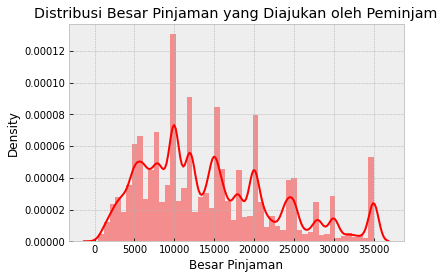

In [ ]:
# Membuat Plot Distribusi besar pinjaman
sns.distplot(loan_amount, color = 'red')
plt.title("Distribusi Besar Pinjaman yang Diajukan oleh Peminjam")
plt.xlabel("Besar Pinjaman")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


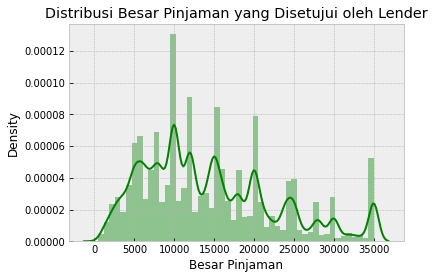

In [ ]:
sns.distplot(funded_amount, color = 'green')
plt.title("Distribusi Besar Pinjaman yang Disetujui oleh Lender")
plt.xlabel("Besar Pinjaman")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


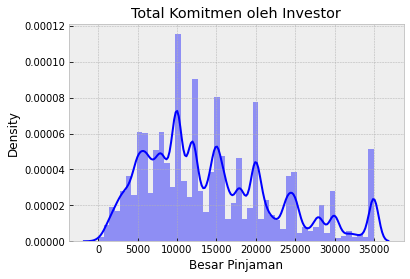

In [ ]:
sns.distplot(investor_committment, color = 'blue')
plt.title("Total Komitmen oleh Investor")
plt.xlabel("Besar Pinjaman")
plt.show()

In [ ]:
# Ubah tanggal ke bentuk datetime
loan_df['issue_d'] = [date[:4] + '20' + date[4:] for date in loan_df['issue_d']]
loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'], format = "%b-%Y")
loan_df['issue_d']

0        2011-12-01
1        2011-12-01
2        2011-12-01
3        2011-12-01
4        2011-12-01
            ...    
466280   2014-01-01
466281   2014-01-01
466282   2014-01-01
466283   2014-01-01
466284   2014-01-01
Name: issue_d, Length: 466285, dtype: datetime64[ns]

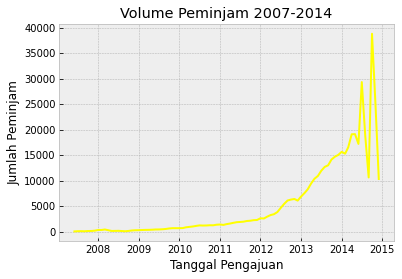

In [ ]:
# Groupby Issue_d
volume_peminjam_per_bulan = loan_df.groupby('issue_d')['id'].count().to_frame().reset_index()

# Buat Plot Peminjaman
plt.plot(volume_peminjam_per_bulan['issue_d'], volume_peminjam_per_bulan['id'], color = 'yellow')
plt.title("Volume Peminjam 2007-2014")
plt.xlabel("Tanggal Pengajuan")
plt.ylabel("Jumlah Peminjam")
plt.show()

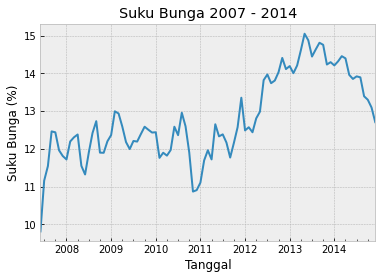

In [ ]:
# Suku Bunga Lender

interest_rate_by_month = loan_df.groupby('issue_d')['int_rate'].mean()
interest_rate_by_month.plot()
plt.title("Suku Bunga 2007 - 2014")
plt.xlabel("Tanggal")
plt.ylabel("Suku Bunga (%)")
plt.show()

In [ ]:
# Volume
loan_df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

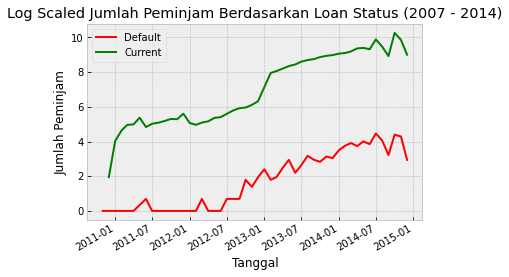

In [ ]:
# Subset peminjam yang default
default_df = loan_df[loan_df['loan_status'] == 'Default']
current_df = loan_df[loan_df['loan_status'] == 'Current']

# Group by tanggal dan lakukan transformasi logaritma
volume_default = np.log(default_df.groupby('issue_d')['id'].count())
volume_current= np.log(current_df.groupby('issue_d')['id'].count())

# Plot
volume_default.plot(color = 'red', label = 'Default')
volume_current.plot(color = 'green', label = 'Current')

plt.title("Log Scaled Jumlah Peminjam Berdasarkan Loan Status (2007 - 2014)")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Peminjam")
plt.legend()
plt.show()

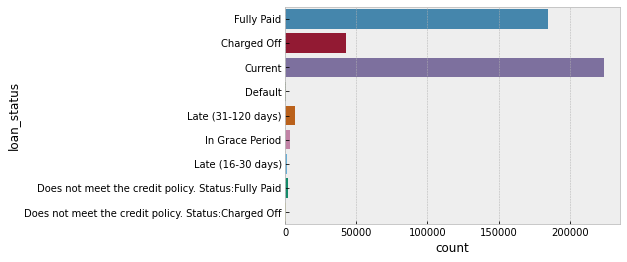

In [ ]:
# Distribusi loan_status
sns.countplot(y='loan_status', data=loan_df)
plt.show()

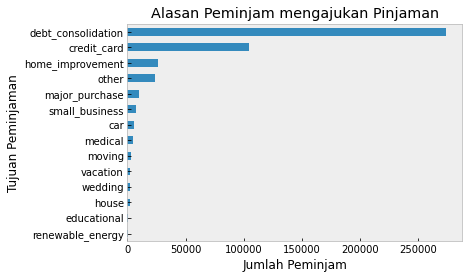

In [ ]:
# Tujuan Peminjaman
volume_purpose = loan_df.groupby('purpose')['id'].count().sort_values(ascending = True)
volume_purpose.plot(kind = 'barh')
plt.ylabel("Tujuan Peminjaman")
plt.xlabel("Jumlah Peminjam")
plt.title("Alasan Peminjam mengajukan Pinjaman")
plt.grid(False)
plt.show()

In [ ]:
# Persebaran Pinjaman yang Bermasalah
loan_df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


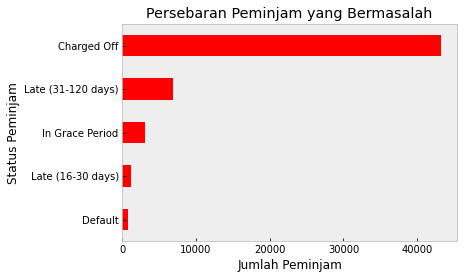

In [ ]:
# Ubah kategori yang "Does not meet the credit policy"
loan_df['loan_status'] = loan_df['loan_status'].str.replace('Does not meet the credit policy. Status:Fully Paid','Fully Paid')
loan_df['loan_status'] = loan_df['loan_status'].str.replace('Does not meet the credit policy. Status:Charged Off','Charged Off')

# Subset ke pinjaman yang bermasalah
delinquent_loans = ['Charged Off','Default','Late (31-120 days)','In Grace Period','Late (16-30 days)']
delinquent_df = loan_df[loan_df['loan_status'].isin(delinquent_loans)]

# Liat persebarannya
volume_delinquents = delinquent_df.groupby('loan_status')['id'].count().sort_values()
volume_delinquents.plot(kind = 'barh', color = 'red')
plt.xlabel("Jumlah Peminjam")
plt.ylabel("Status Peminjam")
plt.title("Persebaran Peminjam yang Bermasalah")
plt.grid(False)
plt.show()

Paling banyak peminjam bertipe Charged Off (berarti peminjam ini sudah dipastikan oleh Lender akan bermasalah dalam pengembalian pinjamannya)

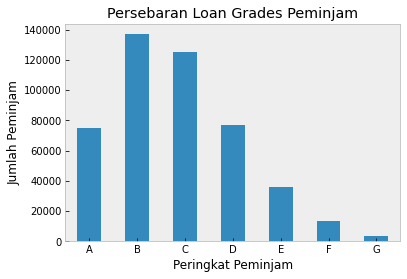

In [ ]:
# Persebaran Loan Grades

volume_grades = loan_df.groupby('grade')['id'].count()
volume_grades.plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.xlabel("Peringkat Peminjam")
plt.ylabel("Jumlah Peminjam")
plt.title("Persebaran Loan Grades Peminjam")
plt.grid(False)
plt.show()

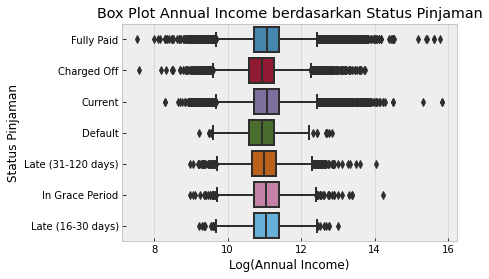

In [ ]:
# Hubungannya dengan Risiko Pinjaman
sns.boxplot(x = np.log(loan_df['annual_inc']), y = loan_df['loan_status'])
plt.title("Box Plot Annual Income berdasarkan Status Pinjaman")
plt.xlabel("Log(Annual Income)")
plt.ylabel("Status Pinjaman")
plt.show()

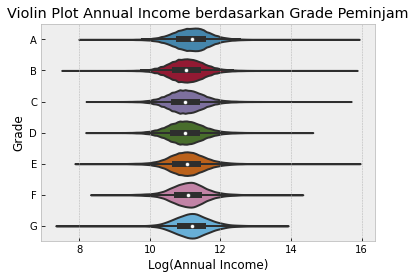

In [ ]:
# Hubungannya dengan Grade
sns.violinplot(x = np.log(loan_df['annual_inc']), y = loan_df['grade'].sort_values())
plt.title("Violin Plot Annual Income berdasarkan Grade Peminjam")
plt.xlabel("Log(Annual Income)")
plt.ylabel("Grade")
plt.show()

In [ ]:
# Buat data baru
loan_df['emp_title'] = loan_df['emp_title'].str.lower().str.capitalize()
loan_df['emp_title'] = loan_df['emp_title'].str.replace('Rn','Registered Nurse')
no_na_df = loan_df.loc[:, ['emp_title']].fillna('Unknown')

count_job = no_na_df['emp_title'].value_counts().to_frame().reset_index()
count_job.columns = ['emp_title','counts']

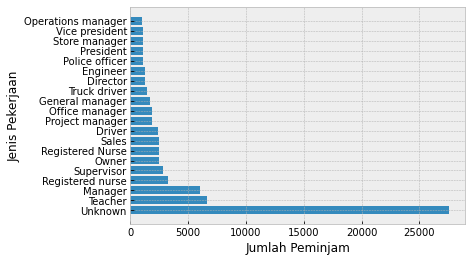

In [ ]:
# Buat visualisasi
plt.barh(y = count_job['emp_title'][:20], width = count_job['counts'][:20])
plt.xlabel("Jumlah Peminjam")
plt.ylabel("Jenis Pekerjaan")
plt.show()

Dapat diamati bahwa paling banyak tidak diketahui (unknown)

In [ ]:
# Data Preparation
# Split Data

loan_df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


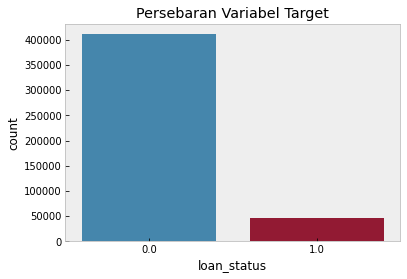

In [ ]:
# Persebaran label variabel target
# split dulu datanya menjadi variabel prediktor dan variabel target
X = loan_df.drop('loan_status', axis = 1)
y = loan_df['loan_status']

# Bikin dict Target
dict_target = {'Fully Paid' : 0,
               'Current' : 0,
               'Charged Off' : 1,
               'Default' : 1,
               'Late' : 1,
               'In Grace Period' : 1}
               
# Label encoding
y = y.map(dict_target)

# Lihat persebarannya
sns.countplot(y)
plt.title("Persebaran Variabel Target")
plt.grid(False)
plt.show()

Ada ketidakseimbangan target dalam permasalahan klasifikasi ini jadi perlu ditangani saat pemodelan nanti dengan menggunakan algoritma SMOTE

In [ ]:
y.isnull().sum()

8118

In [ ]:
y = y.fillna(1)

In [ ]:
# Split Training dan Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 111, stratify = y)

In [ ]:
X_train = X_train.reset_index().drop(['Unnamed: 0', 'index'], axis = 1)
y_train = y_train.reset_index().drop(['index'], axis = 1)
y_train = np.array(y_train).flatten()

X_test = X_test.reset_index().drop(['Unnamed: 0','index'], axis = 1)
y_test = y_test.reset_index().drop(['index'], axis = 1)
y_test = np.array(y_test).flatten()

In [ ]:
# Missing Values

# Drop missing values di fitur yang memiliki semua nilai NA
most_na_train_features = [col for col in X_train.columns if (X_train[col].isna().sum()*100)/len(X_train) >= 70]
most_na_test_features = [col for col in X_test.columns if (X_test[col].isna().sum()*100)/len(X_test) >= 70]

X_train = X_train.drop(most_na_train_features, axis = 1)
X_test = X_test.drop(most_na_test_features, axis = 1)

print("Feature training shape: ",X_train.shape)
print("Feature testing shape: ",X_test.shape)

Feature training shape:  (326399, 53)
Feature testing shape:  (139886, 53)


Ada 53 kolom yang tersedia

In [ ]:
# Training null values
X_train.isnull().sum().sort_values()

id                                 0
addr_state                         0
dti                                0
policy_code                        0
revol_bal                          0
initial_list_status                0
out_prncp                          0
out_prncp_inv                      0
total_pymnt                        0
total_pymnt_inv                    0
total_rec_prncp                    0
total_rec_int                      0
total_rec_late_fee                 0
recoveries                         0
collection_recovery_fee            0
last_pymnt_amnt                    0
zip_code                           0
purpose                            0
application_type                   0
funded_amnt                        0
url                                0
installment                        0
int_rate                           0
term                               0
home_ownership                     0
funded_amnt_inv                    0
sub_grade                          0
g

In [ ]:
X_train['mths_since_last_delinq'].unique()

array([ nan,  19.,  49.,  14.,  31.,  60.,  76.,  26.,  68.,  15.,  39.,
         7.,  23.,  18.,  28.,  71.,   9.,  24.,  10.,  48.,  57.,  36.,
        27.,  81.,  12.,  69.,  47.,  37.,  11.,  58.,  40.,   1.,  44.,
        52.,  38.,  21.,  20.,  16.,   5.,  33.,  45.,  74.,  30.,   0.,
        13.,  72.,  29.,   6.,  55.,  53.,  32.,   4.,  50.,  64.,  22.,
        17.,  35.,  56.,  51.,  77.,  80.,  34.,  43.,  99.,  65.,  25.,
        61.,  66.,  75.,   8.,   3.,  42.,  41.,  73.,  46.,  79.,  78.,
        70.,  63.,  59.,  54.,  62.,   2.,  67., 105., 103.,  82.,  83.,
       130., 119.,  91.,  85.,  86., 114.,  93., 151.,  88.,  87., 104.,
       120., 188.,  97., 111.,  84., 108., 135., 148.,  90.,  95.,  92.,
       127., 107.,  94., 131.,  96., 124., 100.,  89., 106., 126., 139.,
       101., 113., 121., 116., 115., 110., 102., 156., 170., 159., 140.,
       133., 143., 122., 134.,  98., 109., 118., 149., 141.])

In [ ]:
missing_mths_last_delinq = X_train[X_train['mths_since_last_delinq'].isna() == True]
missing_mths_last_delinq.groupby('grade')['id'].count()

grade
A    35797
B    52066
C    44256
D    25795
E    11799
F     4333
G     1016
Name: id, dtype: int64

Peminjam yang fiturnya bernilai NaN sebagian besar berasal dari grade B, C dan A, jadi peminjamnya cenderung menepati deadline jika dilihat dari peringkat ini. Strategi untuk mengisi null values disini bisa dengan mengikuti peringkatnya.

In [ ]:
dict(X_train.groupby('grade')['mths_since_last_delinq'].median())

{'A': 34.0, 'B': 32.0, 'C': 30.0, 'D': 30.0, 'E': 29.0, 'F': 28.0, 'G': 25.0}

In [ ]:
# Imputasi dengan grade
def mths_since_last_delinq_imputer(data):
  # Group by grade dan hitung median mths_since_last_delinq
  grade_mths_since_last_delinq = data.groupby('grade')['mths_since_last_delinq'].median()
  dict_grade_mths_since_last_delinq = dict(grade_mths_since_last_delinq)

  # Isi missing values berdasarkan gradenya
  for i in range(len(data)):
    if pd.isna(data['mths_since_last_delinq'][i]) == True:
      data['mths_since_last_delinq'][i] = dict_grade_mths_since_last_delinq[data['grade'][i]]
  
  # return data
  return data

In [ ]:
X_train = mths_since_last_delinq_imputer(X_train)
X_test = mths_since_last_delinq_imputer(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Sanity Check
X_train['mths_since_last_delinq'].isnull().sum()

0

In [ ]:
X_train['next_pymnt_d'].unique()

array(['Feb-16', nan, 'Jan-16', 'Jun-09', 'Apr-10', 'Nov-09', 'Apr-11',
       'Jun-11', 'Oct-12', 'Aug-10', 'Sep-12', 'Jan-12', 'Dec-09',
       'May-11', 'Nov-10', 'Jul-11', 'Apr-13', 'Mar-12', 'Apr-12',
       'Feb-12', 'Aug-12', 'Oct-11', 'Sep-13', 'Sep-11', 'Aug-13',
       'Oct-09', 'Jun-12', 'Jun-10', 'Aug-11', 'Jan-08', 'Jan-15',
       'Nov-12', 'Mar-11', 'Dec-10', 'Mar-10', 'Dec-08', 'Oct-13',
       'Dec-11', 'Feb-11', 'Apr-09', 'Nov-11', 'Jan-10', 'May-13',
       'Sep-09', 'Jul-10', 'Jan-11', 'May-12', 'Jun-13', 'Jul-12',
       'Aug-15', 'May-15', 'Sep-15', 'Sep-10', 'Mar-14', 'Sep-14',
       'Nov-13', 'Oct-10', 'Dec-13', 'Feb-10', 'Jun-15', 'Oct-15',
       'Mar-13', 'Jul-09', 'Feb-13', 'Jan-09', 'Jan-13', 'Mar-16',
       'Jul-13', 'Apr-14', 'May-09', 'Apr-15', 'Feb-14', 'Nov-14',
       'Feb-15', 'Dec-12', 'Oct-08', 'Aug-08', 'Dec-14', 'Mar-15',
       'Aug-14', 'Aug-09', 'Jan-14', 'Mar-09', 'Apr-08', 'May-10',
       'Oct-14', 'May-14', 'Sep-08', 'Nov-08', 'Nov-15', 

In [ ]:
def next_payment_day_imputer(data):
  data['next_pymnt_d'] = data['next_pymnt_d'].fillna("Dec-16")
  data['next_pymnt_d'] = [date[:4] + '20' + date[4:] for date in data['next_pymnt_d']]
  data['next_pymnt_d'] = pd.to_datetime(data['next_pymnt_d'], format = "%b-%Y")
  data['diff_next_pymnt_d'] = pd.to_datetime('2016-12-01') - data['next_pymnt_d']
  data['diff_next_pymnt_d'] = data['diff_next_pymnt_d'].dt.days
  return data

In [ ]:
X_train = next_payment_day_imputer(X_train)
X_test = next_payment_day_imputer(X_test)

In [ ]:
X_train.drop('next_pymnt_d', axis = 1, inplace = True)
X_test.drop('next_pymnt_d', axis = 1, inplace = True)

In [ ]:
X_train['total_rev_hi_lim'].unique()

array([ 37200.,  14100.,  26800., ...,  50690., 106950.,  22059.])

In [ ]:
X_train.groupby('grade')['total_rev_hi_lim'].median()

grade
A    34800.0
B    23400.0
C    20700.0
D    19400.0
E    20200.0
F    19700.0
G    21200.0
Name: total_rev_hi_lim, dtype: float64

In [ ]:
# Imputasi dengan grade
def total_rev_hi_lim_impute(data):
  # Group by grade dan hitung median mths_since_last_delinq
  grade_total_rev_hi_lim = data.groupby('grade')['total_rev_hi_lim'].median()
  dict_grade_total_rev_hi_lim = dict(grade_total_rev_hi_lim)

  # Isi missing values berdasarkan gradenya
  for i in range(len(data)):
    if pd.isna(data['total_rev_hi_lim'][i]) == True:
      data['total_rev_hi_lim'][i] = dict_grade_total_rev_hi_lim[data['grade'][i]]
  
  # return data
  return data

In [ ]:
X_train = total_rev_hi_lim_impute(X_train)
X_test = total_rev_hi_lim_impute(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Imputasi dengan grade
def tot_coll_amt_impute(data):
  # Group by grade dan hitung median mths_since_last_delinq
  grade_tot_coll_amt = data.groupby('grade')['tot_coll_amt'].median()
  dict_grade_tot_coll_amt = dict(grade_tot_coll_amt)

  # Isi missing values berdasarkan gradenya
  for i in range(len(data)):
    if pd.isna(data['tot_coll_amt'][i]) == True:
      data['tot_coll_amt'][i] = dict_grade_tot_coll_amt[data['grade'][i]]
  
  # return data
  return data

In [ ]:
X_train = tot_coll_amt_impute(X_train)
X_test = tot_coll_amt_impute(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
X_train.isnull().sum().sort_values()

id                                0
dti                               0
total_rev_hi_lim                  0
revol_bal                         0
initial_list_status               0
out_prncp                         0
out_prncp_inv                     0
total_pymnt                       0
total_pymnt_inv                   0
total_rec_prncp                   0
total_rec_int                     0
total_rec_late_fee                0
recoveries                        0
collection_recovery_fee           0
last_pymnt_amnt                   0
policy_code                       0
application_type                  0
tot_coll_amt                      0
addr_state                        0
zip_code                          0
mths_since_last_delinq            0
purpose                           0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                    

In [ ]:
# Imputasi dengan grade
def tot_cur_bal_impute(data):
  # Group by grade dan hitung median mths_since_last_delinq
  grade_tot_cur_bal = data.groupby('grade')['tot_cur_bal'].median()
  dict_grade_tot_cur_bal = dict(grade_tot_cur_bal)

  # Isi missing values berdasarkan gradenya
  for i in range(len(data)):
    if pd.isna(data['tot_cur_bal'][i]) == True:
      data['tot_cur_bal'][i] = dict_grade_tot_cur_bal[data['grade'][i]]
  
  # return data
  return data

In [ ]:
X_train = tot_cur_bal_impute(X_train)
X_test = tot_cur_bal_impute(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
X_train['emp_title'].value_counts()[:30]

Teacher                     4656
Manager                     4219
Registered nurse            2278
Supervisor                  2010
Sales                       1712
Owner                       1705
Registered Nurse            1705
Driver                      1629
Project manager             1315
Office manager              1307
General manager             1204
Truck driver                1077
Director                     915
Engineer                     907
Police officer               791
President                    790
Store manager                750
Operations manager           746
Vice president               741
Sales manager                718
Administrative assistant     678
Us army                      667
Attorney                     641
Accountant                   640
Technician                   616
Nurse                        598
Mechanic                     596
Account manager              582
Assistant manager            546
Executive assistant          479
Name: emp_

In [ ]:
X_train['emp_title'] = X_train['emp_title'].fillna("Unknown")
X_test['emp_title'] = X_test['emp_title'].fillna("Unknown")


In [ ]:
X_train['emp_length'].value_counts()

10+ years    105006
2 years       28864
3 years       25674
< 1 year      25471
5 years       21624
1 year        20715
4 years       19612
7 years       18228
6 years       18226
8 years       15745
9 years       12552
Name: emp_length, dtype: int64

In [ ]:
string = '8 years'
import re

string_new = re.sub('years*','', string)
string_new

'8 '

In [ ]:
def emp_length_string_cleaner(string):
  string = string.replace("< 1 year",'0')
  string = re.sub(r'years*','',string)
  string = re.sub(r'\+','',string)
  string = string.strip()
  string = float(string)
  return string

In [ ]:
def emp_length_imputer(data):
  data_not_na = data[data['emp_length'].isna() == False].reset_index().drop('index', axis = 1)
  data_not_na['emp_length'] = data_not_na['emp_length'].apply(emp_length_string_cleaner)
  dict_median_emp_length = dict(data_not_na.groupby('emp_title')['emp_length'].median())

  for i in range(len(data)):
    if pd.isna(data['emp_length'][i]) == True :
      if data['emp_title'][i] not in dict_median_emp_length:
        data['emp_length'][i] = '0'
      else:
        data['emp_length'][i] = str(dict_median_emp_length[data['emp_title'][i]])
  
  data['emp_length'] = data['emp_length'].apply(emp_length_string_cleaner)
  return data

In [ ]:
X_train = emp_length_imputer(X_train)
X_test = emp_length_imputer(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
X_train['emp_length'].unique()

array([ 8. ,  6. , 10. ,  3. ,  2. ,  9. ,  7. ,  4. ,  0. ,  5. ,  1. ,
        3.5,  0.5,  2.5,  6.5,  9.5,  8.5])

In [ ]:
X_train.isnull().sum().sort_values()

id                              0
total_rev_hi_lim                0
revol_bal                       0
initial_list_status             0
out_prncp                       0
out_prncp_inv                   0
total_pymnt                     0
total_pymnt_inv                 0
total_rec_prncp                 0
total_rec_int                   0
total_rec_late_fee              0
recoveries                      0
collection_recovery_fee         0
last_pymnt_amnt                 0
policy_code                     0
application_type                0
tot_coll_amt                    0
tot_cur_bal                     0
dti                             0
addr_state                      0
mths_since_last_delinq          0
emp_length                      0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade         

Ada 13 kolom yang masih mengandung missing values, yaitu : annual_inc, title, pub_rec, total_acc, inq_last_6mths, acc_now_delinq, earliest_cr_line, delinq_2yrs, open_acc, last_credit_pull_d, collections_12_mths_ex_med, revol_util, last_pymnt_d

In [ ]:
# Modus dalam kolom missing values

another_na_features = ['annual_inc', 'title', 'pub_rec', 'total_acc',
                       'inq_last_6mths', 'acc_now_delinq', 'earliest_cr_line', 'delinq_2yrs',
                       'open_acc', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'revol_util',
                       'last_pymnt_d']

for col in another_na_features:
  print("Modus fitur {} :".format(col))
  print(loan_df[col].value_counts().index[0])
  print("")

Modus fitur annual_inc :
60000.0

Modus fitur title :
Debt consolidation

Modus fitur pub_rec :
0.0

Modus fitur total_acc :
21.0

Modus fitur inq_last_6mths :
0.0

Modus fitur acc_now_delinq :
0.0

Modus fitur earliest_cr_line :
Oct-00

Modus fitur delinq_2yrs :
0.0

Modus fitur open_acc :
9.0

Modus fitur last_credit_pull_d :
Jan-16

Modus fitur collections_12_mths_ex_med :
0.0

Modus fitur revol_util :
0.0

Modus fitur last_pymnt_d :
Jan-16



In [ ]:
# Buat fungsi imputasi modus
def feature_mode_imputer(data, feature):
  data[feature] = data[feature].fillna(data[feature].value_counts().index[0])
  return data

# Terapkan pada setiap kolom yang mengandung null values
for col in another_na_features:
  X_train = feature_mode_imputer(X_train, col)
  X_test = feature_mode_imputer(X_test, col)

In [ ]:
def date_to_int(data, date_feature):
  data[date_feature] = [date[:4] + '20' + date[4:] if date[-2] == '0' or (date[-2] == '1' and date[-1] <= '6') else date[:4] + '19' + date[4:] for date in data[date_feature]]
  data[date_feature] = pd.to_datetime(data[date_feature], format = "%b-%Y")
  data[date_feature] = pd.to_datetime('2016-12-01') - data[date_feature]
  data[date_feature] = data[date_feature].dt.days  
  return data

In [ ]:
date_columns = ['last_pymnt_d','last_credit_pull_d','earliest_cr_line']

for col in date_columns:
  X_train = date_to_int(X_train, col)
  X_test = date_to_int(X_test, col)

# Sanity Check
X_train[date_columns]

,last_pymnt_d,last_credit_pull_d,earliest_cr_line
0,335,335,6424
1,366,335,2375
2,335,335,7215
3,335,335,5267
4,549,366,6485
...,...,...,...
326394,366,335,6850
326395,1096,1065,9619
326396,853,335,6148
326397,761,457,6697


In [ ]:
mask = X_train['earliest_cr_line'] < 0
X_train[mask]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,diff_next_pymnt_d


In [ ]:
# Tes Null Values

print("1. Missing values in training data : \n", X_train.isnull().sum())
print("======================================== \n")
print("2. Missing values in testing data : \n", X_test.isnull().sum())

1. Missing values in training data : 
 id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
pymnt_plan                    0
url                           0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
mths_since_last_delinq        0
open_acc                      0
pub_rec                       0
revol_bal                     0
r

Null Values sudah kosong

In [ ]:
# Feature Engineering

X_train.iloc[:,:20].head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,title
0,11404701,13336855,16000,16000,15925.0,36 months,7.90,500.65,A,A4,Officer,8.0,MORTGAGE,53000.0,Source Verified,2014-01-01,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Credit card refinancing
1,19105382,21308133,6000,6000,6000.0,36 months,13.35,203.18,C,C2,Driver,6.0,RENT,56000.0,Verified,2014-06-01,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation
2,3096419,3768803,3000,3000,3000.0,36 months,12.12,99.82,B,B3,Silgan containers inc.,10.0,MORTGAGE,50000.0,Not Verified,2013-01-01,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,CREDIT CARD CONSOLIDATION
3,13878081,15930405,12000,12000,12000.0,36 months,12.49,401.39,B,B4,Office manager,10.0,MORTGAGE,65000.0,Not Verified,2014-04-01,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation
4,36078320,38789845,8000,8000,8000.0,36 months,14.99,277.29,C,C5,Store manager,10.0,MORTGAGE,44000.0,Source Verified,2014-11-01,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation


In [ ]:
# Drop features
X_train = X_train.drop(['id','member_id','sub_grade','issue_d','pymnt_plan','url','title','zip_code','addr_state'], axis = 1)
X_test = X_test.drop(['id','member_id','sub_grade','issue_d','pymnt_plan','url','title','zip_code','addr_state'], axis = 1)

In [ ]:
X_train.shape

(326399, 44)

Sisa kolom ada 44

In [ ]:
# Feature Manipulation

X_train['term'] = X_train['term'].str.replace(r'months','').str.strip().astype('int64')
X_test['term'] = X_test['term'].str.replace(r'months','').str.strip().astype('int64')

In [ ]:
X_train['term']

0         36
1         36
2         36
3         36
4         36
          ..
326394    60
326395    36
326396    36
326397    36
326398    36
Name: term, Length: 326399, dtype: int64

In [ ]:
pd.Series(y_train)

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
326394    0.0
326395    0.0
326396    0.0
326397    0.0
326398    0.0
Length: 326399, dtype: float64

In [ ]:
len(y_train)

326399

In [ ]:
train = pd.concat([X_train, pd.Series(y_train)], axis = 1)
train = train.rename({0:'is_default'}, axis = 1)
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,diff_next_pymnt_d,is_default
0,16000,16000,15925.0,36,7.90,500.65,A,Officer,8.0,MORTGAGE,...,335,0.0,1,INDIVIDUAL,0.0,0.0,211643.0,37200.0,304,0.0
1,6000,6000,6000.0,36,13.35,203.18,C,Driver,6.0,RENT,...,335,0.0,1,INDIVIDUAL,0.0,500.0,21107.0,14100.0,0,0.0
2,3000,3000,3000.0,36,12.12,99.82,B,Silgan containers inc.,10.0,MORTGAGE,...,335,0.0,1,INDIVIDUAL,0.0,0.0,83066.0,26800.0,0,0.0
3,12000,12000,12000.0,36,12.49,401.39,B,Office manager,10.0,MORTGAGE,...,335,0.0,1,INDIVIDUAL,0.0,0.0,297741.0,33400.0,304,0.0
4,8000,8000,8000.0,36,14.99,277.29,C,Store manager,10.0,MORTGAGE,...,366,0.0,1,INDIVIDUAL,0.0,0.0,125013.0,8800.0,0,0.0


In [ ]:
# Groupby Grade
grade_default = train.groupby('grade')['is_default'].sum()/train.shape[0]
dict_grade_default = dict(grade_default)
dict_grade_default

{'A': 0.006743280463481812,
 'B': 0.025095052374547715,
 'C': 0.03341309256462183,
 'D': 0.027601187503638186,
 'E': 0.016204093762542164,
 'F': 0.007441812015355439,
 'G': 0.0021660605577835715}

In [ ]:
# Map
X_train['grade'] = X_train['grade'].map(dict_grade_default)
X_test['grade'] = X_test['grade'].map(dict_grade_default)

In [ ]:
# Modelling

over = SMOTE()
under = RandomUnderSampler()

In [ ]:
# Model Linear
X_train_linear = pd.get_dummies(X_train.drop('emp_title', axis = 1))
X_test_linear = pd.get_dummies(X_test.drop('emp_title', axis = 1))

In [ ]:
# ambil 20 kolom terbaik
selector = SelectKBest(score_func = f_classif, k = 20)
selector.fit(X_train_linear, y_train)
cols = selector.get_support(indices = True)
X_train_linear= X_train_linear.iloc[:,cols]
X_test_linear = X_test_linear.reindex(labels = X_train_linear.columns, axis = 1)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [32 62] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
cols

array([ 3,  4,  8,  9, 12, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30,
       35, 36, 37])

In [ ]:
X_train_linear

,term,int_rate,annual_inc,dti,inq_last_6mths,revol_util,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,tot_cur_bal,total_rev_hi_lim,diff_next_pymnt_d
0,36,7.90,53000.0,21.64,3.0,62.6,6217.92,6188.77,11514.950000,11460.97,9782.08,0.0,0.0,0.0,335,500.65,335,211643.0,37200.0,304
1,36,13.35,56000.0,22.45,0.0,40.1,0.00,0.00,6987.930000,6987.93,6000.00,0.0,0.0,0.0,366,3533.87,335,21107.0,14100.0,0
2,36,12.12,50000.0,10.22,0.0,57.2,0.00,0.00,3593.302492,3593.30,3000.00,0.0,0.0,0.0,335,99.60,335,83066.0,26800.0,0
3,36,12.49,65000.0,20.09,0.0,82.0,5547.60,5547.60,8429.190000,8429.19,6452.40,0.0,0.0,0.0,335,401.39,335,297741.0,33400.0,304
4,36,14.99,44000.0,39.74,0.0,53.1,0.00,0.00,8644.300000,8644.30,8000.00,0.0,0.0,0.0,549,6993.88,366,125013.0,8800.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326394,60,18.24,100000.0,19.38,1.0,97.7,24042.96,24042.96,13017.410000,13017.41,5957.04,0.0,0.0,0.0,366,765.73,335,47860.0,16000.0,304
326395,36,7.51,35000.0,7.71,1.0,60.5,0.00,0.00,8335.180000,8335.18,7575.00,0.0,0.0,0.0,1096,3405.56,1065,144910.0,34800.0,0
326396,36,7.62,111000.0,8.41,0.0,36.3,0.00,0.00,26617.421600,26617.42,24000.00,0.0,0.0,0.0,853,8674.57,335,144910.0,34800.0,0
326397,36,13.11,81000.0,15.11,1.0,49.6,0.00,0.00,5779.626279,5779.63,5000.00,0.0,0.0,0.0,761,2915.46,457,138055.0,14900.0,0


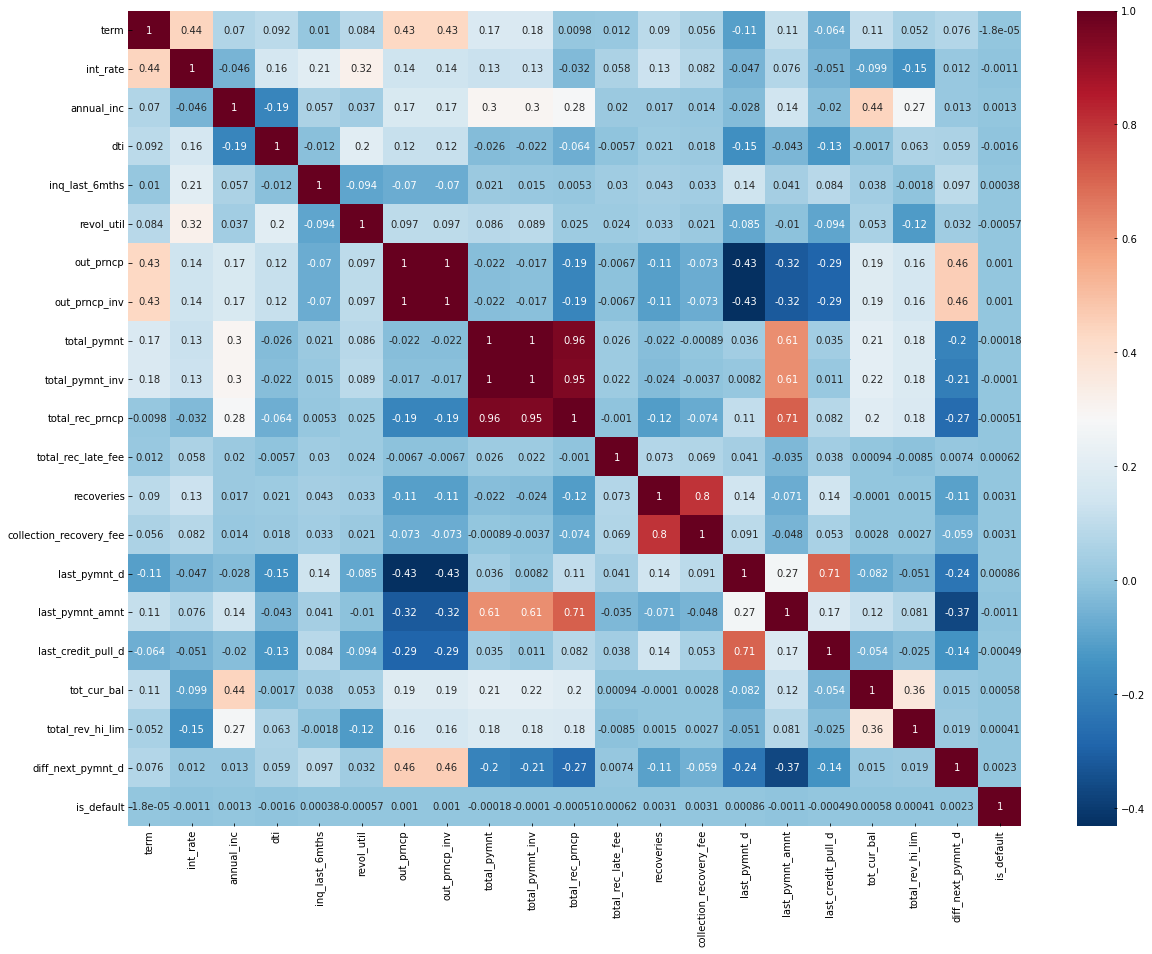

In [ ]:
# Heatmap
plt.figure(figsize=(20,15))
data_linear = pd.concat([X_train_linear, X_test_linear], axis = 0)
data_linear['is_default'] = y
corr = data_linear.corr()
sns.heatmap(corr, cmap='RdBu_r', annot=True)
plt.show()

In [ ]:
X_train_linear = X_train_linear.drop(['total_pymnt_inv','out_prncp_inv'], axis = 1)
X_test_linear = X_test_linear.drop(['total_pymnt_inv','out_prncp_inv'], axis = 1)

In [ ]:
# Logistic Regression
# Buat Pipeline
logreg = LogisticRegression(max_iter = 1000)

pipeline_logreg = Pipeline(steps = [('scaler', StandardScaler()),
                                    ('over', over),
                                    ('under', under),
                                    ('model', logreg)])

scores_logreg = cross_val_score(pipeline_logreg, X_train_linear, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores_logreg))

Mean ROC AUC: 0.936


Skor ROC AUC sebesar 0.936

In [ ]:
# Diagnostic
# Fit
pipeline_logreg.fit(X_train_linear, y_train)

# Predict
y_predict_logreg = pipeline_logreg.predict(X_test_linear)

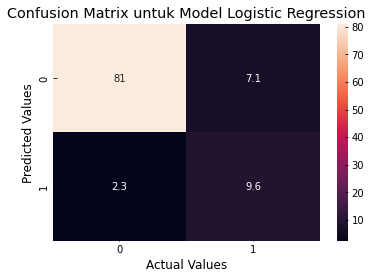

In [ ]:
# Liat confusion matrix
conf_matrix_logreg = confusion_matrix(y_test, y_predict_logreg)
conf_matrix_percentage_logreg = (conf_matrix_logreg/X_test_linear.shape[0])*100
sns.heatmap(conf_matrix_percentage_logreg, annot = True)
plt.title("Confusion Matrix untuk Model Logistic Regression")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Sekitar 81% peminjam yang diprediksi tidak akan default dan peminjam tersebut memang tidak default

Sekitar 7.1% peminjam yang diprediksi tidak akan default tetapi peminjam tersebut default

Sekitar 2.3% peminjam yang diprediksi akan default tetapi peminjam tersebut tidak default

Sekitar 9.6% peminjam yang diprediksi akan default dan peminjam tersebut default 

In [ ]:
# Liat classification reportnya
print(classification_report(y_test, y_predict_logreg))

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95    123286
         1.0       0.58      0.81      0.67     16600

    accuracy                           0.91    139886
   macro avg       0.77      0.86      0.81    139886
weighted avg       0.93      0.91      0.91    139886



Akurasi yang diperoleh sebesar 91% menandakan perhitungan cukup bagus

In [ ]:
# Liat ROC-AUC Curve
## generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
## Prediksi peluangnya
y_pred_prob_lr = pipeline_logreg.predict_proba(X_test_linear)
## Ambil peluang untuk yang level 1
lr_probs = y_pred_prob_lr[:, 1]
## calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
## summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.936


In [ ]:
# Support Vector Machine

# Buat Pipeline
SVM = LinearSVC()

pipeline_svm = Pipeline(steps = [('scaler', StandardScaler()),
                                    ('over', over),
                                    ('under', under),
                                    ('model', SVM)])

scores_svm = cross_val_score(pipeline_svm, X_train_linear, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores_svm))

Mean ROC AUC: 0.935


Skor ROC AUC = 0.935

In [ ]:
# Diagnostic
# Fit
pipeline_svm.fit(X_train_linear, y_train)

# Predict
y_predict_svm = pipeline_svm.predict(X_test_linear)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


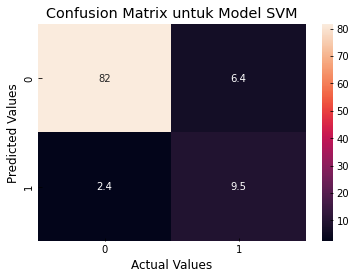

In [ ]:
# Liat confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_predict_svm)
conf_matrix_percentage_svm = (conf_matrix_svm/X_test_linear.shape[0])*100
sns.heatmap(conf_matrix_percentage_svm, annot = True)
plt.title("Confusion Matrix untuk Model SVM")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Sekitar 82% peminjam yang diprediksi tidak akan default dan peminjam tersebut memang tidak default

Sekitar 6.6% peminjam yang diprediksi tidak akan default tetapi peminjam tersebut default

Sekitar 2.3% peminjam yang diprediksi akan default tetapi peminjam tersebut tidak default

Sekitar 9.5% peminjam yang diprediksi akan default dan peminjam tersebut default

In [ ]:
# Liat classification reportnya
print(classification_report(y_test, y_predict_svm))

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95    123286
         1.0       0.60      0.80      0.68     16600

    accuracy                           0.91    139886
   macro avg       0.78      0.86      0.82    139886
weighted avg       0.93      0.91      0.92    139886



Akurasi yang diperoleh 91% menandakan perhitungan cukup bagus

In [ ]:
# Linear Discriminant Analysis

# Buat Pipeline
LDA = LinearDiscriminantAnalysis()

pipeline_lda = Pipeline(steps = [('scaler', StandardScaler()),
                                    ('over', over),
                                    ('under', under),
                                    ('model', LDA)])

scores_lda = cross_val_score(pipeline_lda, X_train_linear, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores_lda))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean ROC AUC: 0.898


Skor ROC AUC = 0.898

In [ ]:
# Diagnostic
# Fit
pipeline_lda.fit(X_train_linear, y_train)

# Predict
y_predict_lda = pipeline_lda.predict(X_test_linear)

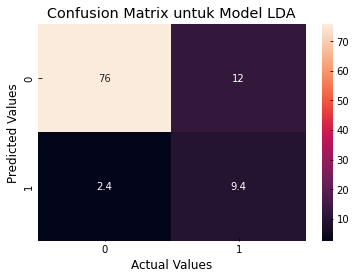

In [ ]:
# Liat confusion matrix
conf_matrix_lda = confusion_matrix(y_test, y_predict_lda)
conf_matrix_percentage_lda = (conf_matrix_lda/X_test_linear.shape[0])*100
sns.heatmap(conf_matrix_percentage_lda, annot = True)
plt.title("Confusion Matrix untuk Model LDA")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Sekitar 76% peminjam yang diprediksi tidak akan default dan peminjam tersebut memang tidak default

Sekitar 12% peminjam yang diprediksi tidak akan default tetapi peminjam tersebut default

Sekitar 2.4% peminjam yang diprediksi akan default tetapi peminjam tersebut tidak default

Sekitar 9.4% peminjam yang diprediksi akan default dan peminjam tersebut default

In [ ]:
# Liat classification reportnya
print(classification_report(y_test, y_predict_lda))

              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91    123286
         1.0       0.44      0.80      0.56     16600

    accuracy                           0.85    139886
   macro avg       0.70      0.83      0.74    139886
weighted avg       0.91      0.85      0.87    139886



Akurasi yang diperoleh 85% menandakan perhitungan cukup bagus

In [ ]:
# Liat ROC-AUC Curve
## generate a no skill prediction (majority class)
## Prediksi peluangnya
y_pred_prob_lda = pipeline_lda.predict_proba(X_test_linear)
## Ambil peluang untuk yang level 1
lda_probs = y_pred_prob_lr[:, 1]
## calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lda_auc = roc_auc_score(y_test, lda_probs)
## summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LDA: ROC AUC=%.3f' % (lda_auc))

No Skill: ROC AUC=0.500
LDA: ROC AUC=0.936


In [ ]:
# Model Tree

# Decision Tree Classifier
# categorical columns
cat_col_train = [col for col in X_train.columns if X_train[col].dtypes == 'object']
cat_col_test = [col for col in X_test.columns if X_test[col].dtypes == 'object']

In [ ]:
# Label encoding
encoder = LabelEncoder()

# Buat copy Data Train
X_train_tree = X_train.copy()
for col in cat_col_train:
  encoder.fit(X_train[col])
  X_train_tree[col] = encoder.transform(X_train[col])

X_test_tree = X_test.copy()
for col in cat_col_train:
  encoder.fit(X_test[col])
  X_test_tree[col] = encoder.transform(X_test[col])

In [ ]:
# Ambil 20 kolom terbaik
selector = SelectKBest(score_func = f_classif, k = 20)
selector.fit(X_train_tree, y_train)
cols = selector.get_support(indices = True)
X_train_tree = X_train_tree.iloc[:,cols]
X_test_tree = X_test_tree.reindex(labels = X_train_tree.columns, axis = 1)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [37 38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
X_train_tree = X_train_tree.drop(['total_pymnt_inv','out_prncp_inv'], axis = 1)
X_test_tree = X_test_tree.drop(['total_pymnt_inv','out_prncp_inv'], axis = 1)

In [ ]:
# Buat Pipeline
dec_tree = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 1, max_leaf_nodes = None, max_depth = 12)

pipeline_dec_tree = Pipeline(steps = [('over', over),
                                    ('under', under),
                                    ('model', dec_tree)])

scores_dec_tree = cross_val_score(pipeline_dec_tree, X_train_tree, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores_dec_tree))

Mean ROC AUC: 0.980


Skor ROC AUC = 0.98

In [ ]:
# Diagnostic
# Predict
pipeline_dec_tree.fit(X_train_tree, y_train)
y_predict_dec_tree = pipeline_dec_tree.predict(X_test_tree)

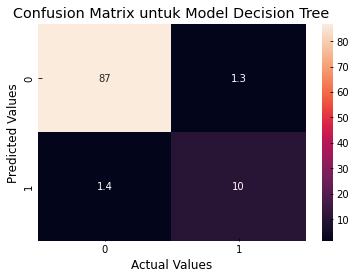

In [ ]:
# Liat confusion matrix
conf_matrix_dec_tree = confusion_matrix(y_test, y_predict_dec_tree)
conf_matrix_percentage_dec_tree = (conf_matrix_dec_tree/X_test_tree.shape[0])*100
sns.heatmap(conf_matrix_percentage_dec_tree, annot = True)
plt.title("Confusion Matrix untuk Model Decision Tree")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Sekitar 87% peminjam yang diprediksi tidak akan default dan peminjam tersebut memang tidak default

Sekitar 1.4% peminjam yang diprediksi tidak akan default tetapi peminjam tersebut default

Sekitar 1.4% peminjam yang diprediksi akan default tetapi peminjam tersebut tidak default

Sekitar 11% peminjam yang diprediksi akan default dan peminjam tersebut default 

In [ ]:
# Liat classification reportnya
print(classification_report(y_test, y_predict_dec_tree))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98    123286
         1.0       0.89      0.88      0.89     16600

    accuracy                           0.97    139886
   macro avg       0.94      0.93      0.94    139886
weighted avg       0.97      0.97      0.97    139886



Akurasi yang diperoleh 97% dan menjadi akurasi paling tinggi daripada metode sebelumnya

In [ ]:
# Liat ROC-AUC Curve
## generate a no skill prediction (majority class)
## Prediksi peluangnya
y_pred_prob_dectree = pipeline_dec_tree.predict_proba(X_test_tree)
## Ambil peluang untuk yang level 1
dectree_probs = y_pred_prob_dectree[:, 1]
## calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
dectree_auc = roc_auc_score(y_test, dectree_probs)
## summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (dectree_auc))

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.981


In [ ]:
# Random Forest Classifier

# Buat Pipeline
rforest = RandomForestClassifier(max_depth = 3, min_samples_split = 2, min_samples_leaf = 1)

pipeline_rforest = Pipeline(steps = [('over', over),
                                    ('under', under),
                                    ('model', rforest)])

scores_rforest = cross_val_score(pipeline_rforest, X_train_tree, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores_rforest))

Mean ROC AUC: 0.957


In [ ]:
# Predict
pipeline_rforest.fit(X_train_tree, y_train)
y_predict_rforest = pipeline_rforest.predict(X_test_tree)

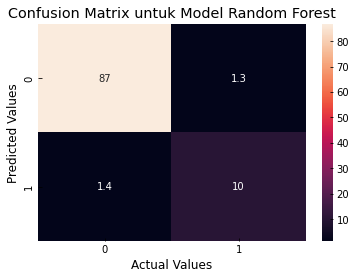

In [ ]:
# Liat confusion matrix
conf_matrix_rforest = confusion_matrix(y_test, y_predict_rforest)
conf_matrix_percentage_rforest = (conf_matrix_rforest/X_test_tree.shape[0])*100
sns.heatmap(conf_matrix_percentage_dec_tree, annot = True)
plt.title("Confusion Matrix untuk Model Random Forest")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Sekitar 87% peminjam yang diprediksi tidak akan default dan peminjam tersebut memang tidak default

Sekitar 1.3% peminjam yang diprediksi tidak akan default tetapi peminjam tersebut default

Sekitar 1.4% peminjam yang diprediksi akan default tetapi peminjam tersebut tidak default

Sekitar 10% peminjam yang diprediksi akan default dan peminjam tersebut default

In [ ]:
# Liat classification reportnya
print(classification_report(y_test, y_predict_rforest))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    123286
         1.0       0.79      0.76      0.77     16600

    accuracy                           0.95    139886
   macro avg       0.88      0.87      0.87    139886
weighted avg       0.95      0.95      0.95    139886



Akurasi yang diperoleh 95% menandakan perhitungan cukup bagus

In [ ]:
# Liat ROC-AUC Curve
## generate a no skill prediction (majority class)
## Prediksi peluangnya
y_pred_prob_rforest = pipeline_rforest.predict_proba(X_test_tree)
## Ambil peluang untuk yang level 1
rforest_probs = y_pred_prob_rforest[:, 1]
## calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rforest_auc = roc_auc_score(y_test, rforest_probs)
## summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rforest_auc))

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.961


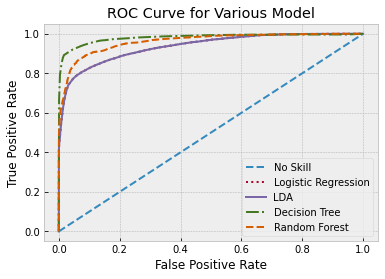

In [ ]:
# Hasil Pemodelan

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lda_fpr, lda_tpr, _ = roc_curve(y_test, lda_probs)
dectree_fpr, dectree_tpr, _ = roc_curve(y_test, dectree_probs)
rforest_fpr, rforest_tpr, _ = roc_curve(y_test, rforest_probs)

plt.style.use('bmh')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, linestyle=':', label='Logistic Regression')
plt.plot(lda_fpr, lda_tpr, linestyle = '-', label='LDA')
plt.plot(dectree_fpr, dectree_tpr, linestyle = '-.', label='Decision Tree')
plt.plot(rforest_fpr, rforest_tpr, linestyle = 'dashed', label='Random Forest')
## axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
## show the legend
plt.legend()
plt.title("ROC Curve for Various Model")
plt.show()

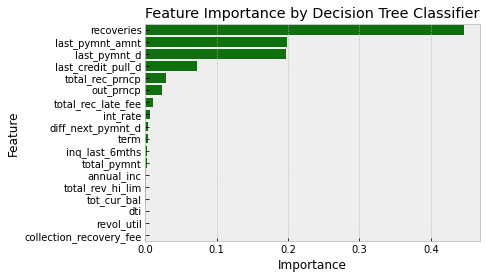

In [ ]:
# Kolom penting

feature_importances = pipeline_dec_tree.named_steps["model"].feature_importances_
feature_names = X_train_tree.columns

dict_fi = {"Feature" : feature_names, "Importance" : feature_importances}
df_fi = pd.DataFrame(dict_fi)

sns.barplot(data = df_fi.sort_values(by = 'Importance', ascending = False), x = 'Importance', y = 'Feature', color = 'green')
plt.title("Feature Importance by Decision Tree Classifier")
plt.show()

kolom recoveries paling berkontribusi dalam model tersebut diikuti oleh last_pymnt_d dan last_pymnt_amnt